## Bayesian Optimization with a Gaussian Process

#### import libraries 

In [1]:
import numpy as np
import pandas as pd
import math
from scipy.optimize import brentq
from bayes_opt import BayesianOptimization

#### load data

In [2]:
# the structure of the data should be tab-separated values with columns:
# current, subs (substrate), elec (electrode material), salt, mode, solvent, PIVOH (equivalents of acid), base, eq_base (equivalents of base), Fmol, yield SM, yield 1, yield 2
df = pd.read_csv("reaction_data.csv", sep="\t")

In [3]:
# you can modify the feature columns as needed to include/exclude specific set of experimental points

X = df[[
    "current",
    "elec",
    "salt",
    "subs",
    "mode",
    "solvent",
    "PIVOH",
    "base",
    "eq_base",
    "Fmol"
    ]]

y2 = df["yield 2"]

#### functions

In [ ]:
def translate_params(params):
    # helper function to translate categorical variables from numeric codes to human-readable strings
    # the mappings should match those used in data preprocessing, but with human-readable labels
    translated = {}
    for key, val in params.items():
        # Process categorical:
        if key == "solvent":
            idx = int(round(val))
            translated["solvent"] = SOLVENTS.get(idx, f"Unknown({idx})")
        
        elif key == "elec":
            idx = int(round(val))
            translated["elec"] = electrodes.get(idx, f"Unknown({idx})")

        elif key == "salt":
            idx = int(round(val))
            translated["salt"] = salts.get(idx, f"Unknown({idx})")

        elif key == "base":
            idx = int(round(val))
            translated["base"] = BASES.get(idx, f"Unknown({idx})")

        elif key == "mode":
            idx = int(round(val))
            translated["mode"] = ACDC_MODES.get(idx, f"Unknown({idx})")

        elif key == "subs":
            idx = int(round(val))
            translated["subs"] = substrates.get(idx, f"Unknown({idx})")

        # Numeric values:
        else:
            translated[key] = float(val)
    return translated

def pretty_print_result(res):

    # helper function to print out the best result nicely, decoding categorical variables into readable form
    print("\n=== Best Predicted Conditions ===")
    print(f"Predicted yield 2: {float(res['target']):.2f}\n")

    params = translate_params(res["params"])
    # params = clean_params(res["params"])
    longest = max(len(k) for k in params.keys())

    for k, v in params.items():
        if isinstance(v, float):
            print(f"{k.ljust(longest)} : {v:6.1f}")
        else:
            print(f"{k.ljust(longest)} : {v}")

    H2O = compute_H2O(
        solvent=int(round(res["params"]["solvent"])),
        PIVOH=res["params"]["PIVOH"],
        base=int(round(res["params"]["base"])),
        eq_base=res["params"]["eq_base"]
    )

    pH = solve_pH_general(
        *conversion_df_to_pH(
            solvent=int(round(res["params"]["solvent"])),
            PIVOH=res["params"]["PIVOH"],
            base_code=int(round(res["params"]["base"])),
            eq_base=res["params"]["eq_base"],
            H2O=H2O
        )
    )['pH']
    print(f"pH".ljust(longest) + " : " + f"{pH:6.1f}"+" (computed)")
    print(f"H2O".ljust(longest) + " : " + f"{H2O:6.3f}"+" (computed)")
    print("===============================\n")

    #let's also plot a tabulated result:
    print("current\tF/mol\telec\tsalt\tsolvent\tPivOH\tbase\teq_base\tyield 2")
    print(f'{params["current"]:.1f}\t{params["Fmol"]:.1f}\t{params["elec"]}\t{params["salt"]}\t{params["solvent"]}\t{params["PIVOH"]:.1f}\t{params["base"]}\t{params["eq_base"]:.1f}')

def compute_H2O(solvent, PIVOH, base, eq_base):
    # function to compute amount of water in solvent mixture based on solvent type and acid/base amounts
    solvent_factor = {0: 0.23, 1: 0.07, 2: 0.027}[solvent]
    acidity_factor = 0 * PIVOH
    base_factor = {0: 6, 1: 1, 2: 0.0013, 3: 0.0013, 4: 0.0013}[base]

    return solvent_factor + acidity_factor + base_factor*eq_base

def alphas_from_pKa_list(h, pKa_list):
    """
    h : [H+] (float)
    pKa_list : list of pKa values [pKa1, pKa2, ...] (length n)
    Returns: list of alphas alpha_0..alpha_n (length n+1)
    
    alphas correspond to fraction of species in each protonation state
    0 = fully protonated, 1 = fully deprotonated
    Constraints:
    0 <= alpha_i <= 1, sum(alpha_i) = 1
    """
    # convert to Ka list
    Ka_list = [10.0**(-p) for p in pKa_list]
    n = len(Ka_list)
    # build Pi list: Pi[0]=1, Pi[1]=K1, Pi[2]=K1*K2, ...
    Pi = [1.0]
    for K in Ka_list:
        Pi.append(Pi[-1] * K) # appends last K element multiplied by K

    powers = [h**(n - m) for m in range(n+1)]
    denom = sum(Pi[m] * powers[m] for m in range(n+1))
    alphas = [(Pi[m] * powers[m]) / denom for m in range(n+1)]
    return alphas

def make_f_logt(acids, base, Kw, added_cations, added_anions):
    """
    returns a function f_logt(t) where t = log10([H+]) that computes positives-negatives.
    acids: list of {'Ca': float, 'pKa_list': [...]}
    base: None or {'C_B': float, 'pKa_BH': float or 'strong'}
    Kw, added_cations, added_anions: floats
    """
    # preprocess base
    if base is None:
        C_B = 0.0
        Ka_BH = None
        strong_base_stoich = 0.0
    else:
        C_B = base.get('C_B', 0.0)
        pKa_BH = base.get('pKa_BH', None)
        if pKa_BH == 'strong':
            Ka_BH = None
            strong_base_stoich = C_B  # we'll treat as added cation/anion if needed externally
            C_B = 0.0
        else:
            Ka_BH = 10.0**(-pKa_BH) if pKa_BH is not None else None
            strong_base_stoich = 0.0

    def f_logt(t):
        h = 10.0**t

        ### positives
        positives = h
        # protonated base
        if Ka_BH is not None and C_B > 0:
            BH = C_B * h / (h + Ka_BH)
            positives += BH
        # include spectator cations (e.g., Na+ from salts)
        positives += added_cations

        ### negatives
        anions = 0.0
        for acid in acids:
            Ca = acid['Ca']
            pKa_list = acid['pKa_list']
            alphas = alphas_from_pKa_list(h, pKa_list)  # our helper
            charge = sum(m * Ca * alphas[m] for m in range(len(alphas)))
            anions += charge

        # OH-
        anions += Kw / h
        # spectator anions
        anions += added_anions

        return positives - anions

    return f_logt

def find_root_logt(f_logt, t_lo=-20, t_hi=20, n_scan=400):
    # this function finds the root of f_logt in log10([H+]) space
    # by scanning and then using brentq in the bracketed region

    ts = np.linspace(t_lo, t_hi, n_scan)
    gs = [f_logt(t) for t in ts]
    
    bracket = None
    for i in range(len(ts)-1):
        if gs[i] == 0:
            return ts[i]
        if gs[i]*gs[i+1] < 0: # here the sign changes, which means that there's a root in between
            bracket = (ts[i], ts[i+1])
            break
    if bracket is None:
        return -100 # return an out-of-bounds value to indicate failure
    t_root = brentq(f_logt, bracket[0], bracket[1]) # find root in bracket with Brent's method, more precise
    return t_root

def solve_pH_general(acids, base=None, Kw=1e-14, added_cations=0.0, added_anions=0.0,
                     t_lo=-18, t_hi=2, n_scan=400, return_details=True):
    """
    acids: list of {'Ca': float, 'pKa_list': [pKa1, pKa2, ...]}
    base: None or {'C_B': float, 'pKa_BH': float or 'strong'}
    Kw: autoprotolysis constant
    added_cations/added_anions: spectator species (M)
    returns dict with [H], pH, and species breakdown (if return_details True)
    """

    f_logt = make_f_logt(acids, base, Kw, added_cations, added_anions)
    t_root = find_root_logt(f_logt, t_lo=-18, t_hi=2, n_scan=400)

    h = 10.0**t_root
    pH = -math.log10(h)

    result = {'H': h, 'pH': pH}

    if return_details:
        species = {'acids': [], 'BHplus': 0.0, 'B_free': 0.0, 'OH': Kw / h,
                   'added_cations': added_cations, 'added_anions': added_anions}
        for acid in acids:
            Ca = acid['Ca']
            pKa_list = acid['pKa_list']
            alphas = alphas_from_pKa_list(h, pKa_list)
            concs = [Ca * a for a in alphas]
            charge = sum(m * concs[m] for m in range(len(concs)))
            species['acids'].append({'Ca': Ca, 'pKa_list': pKa_list, 'alphas': alphas, 'concs': concs, 'charge': charge})
        if base is not None:
            pKa_BH = base.get('pKa_BH', None)
            C_B = base.get('C_B', 0.0)
            if pKa_BH == 'strong':
                # if base is strong, user should have modeled added ions explicitly
                species['BHplus'] = None
                species['B_free'] = None
            else:
                Ka_BH = 10.0**(-pKa_BH) if pKa_BH is not None else None
                if Ka_BH is not None:
                    BH = C_B * h / (h + Ka_BH)
                    species['BHplus'] = BH
                    species['B_free'] = C_B - BH
        result['species'] = species

    return result

def conversion_df_to_pH(solvent, PIVOH, base_code, eq_base,H2O):
    # this function converts the dataframe parameters to the format needed for pH calculation

    K_water=1e-14
    K_methanol=1e-16
    K_ethanol=1e-19
    K_acetonitrile=1e-33

    # fraction of water in the solvent mixture
    if solvent==0:
        fraction_water = H2O / 24.7
        Kw = K_water * fraction_water**2 + K_methanol * (1 - fraction_water)**2
    elif solvent==1:
        fraction_water = H2O / 17.15 
        Kw = K_water * fraction_water**2 + K_ethanol * (1 - fraction_water)**2
    elif solvent==2:
        fraction_water = H2O / 13.5
        Kw = K_water * fraction_water**2 + K_acetonitrile * (1 - fraction_water)**2

    if PIVOH>0:
        if solvent==0:
            acids = [{"Ca": PIVOH, "pKa_list": [9.12]}]
        elif solvent==1:
            acids = [{"Ca": PIVOH, "pKa_list": [10.6]}]
        elif solvent==2:
            acids = [{"Ca": PIVOH, "pKa_list": [21]}]
    else:
        acids = []

    if base_code==0: # TMAOH
        base=None
        added_cations=eq_base #TMA+
        added_anions=0
    elif base_code==1: # DIPA
        if solvent==0:
            base={'C_B': eq_base, 'pKa_BH': 12}
        elif solvent==1:
            base={'C_B': eq_base, 'pKa_BH': 13}
        elif solvent==2:
            base={'C_B': eq_base, 'pKa_BH': 19.5}
        added_cations=0
        added_anions=0
    elif base_code==2: # DIPEA
        if solvent==0:
            base={'C_B': eq_base, 'pKa_BH': 11.5}
        elif solvent==1:
            base={'C_B': eq_base, 'pKa_BH': 12.5}
        elif solvent==2:
            base={'C_B': eq_base, 'pKa_BH': 18.5}
        added_cations=0
        added_anions=0
    elif base_code==3: # PivONa
        base=None
        if solvent==0:
            acids = [{"Ca": PIVOH+eq_base, "pKa_list": [9.12]}]
        elif solvent==1:
            acids = [{"Ca": PIVOH+eq_base, "pKa_list": [10.6]}]
        elif solvent==2:
            acids = [{"Ca": PIVOH+eq_base, "pKa_list": [21]}]
        added_cations=eq_base
        added_anions=0
    elif base_code==4: # AcONa
        base=None
        if solvent==0:
            acids = [{"Ca": PIVOH+eq_base, "pKa_list": [15.5]}]
        elif solvent==1:
            acids = [{"Ca": PIVOH+eq_base, "pKa_list": [15.5]}]
        elif solvent==2:
            acids = [{"Ca": PIVOH+eq_base, "pKa_list": [23.5]}]
        added_cations=eq_base
        added_anions=0

    return acids, base, Kw, added_cations, added_anions

def one_hot_encode(sample_dict, X_columns):
    encoded = {}
    # For each categorical variable, expand into one-hot
    encoded.update({
        f"elec_{sample_dict['elec']}": 1,
        f"solvent_{sample_dict['solvent']}": 1,
        f"salt_{sample_dict['salt']}": 1,
        f"base_{sample_dict['base']}": 1,
        f"mode_{sample_dict['mode']}": 1,
        f"subs_{sample_dict['subs']}": 1,
    })

    # Set all unseen categories to 0
    for col in X_columns:
        if col not in encoded:
            encoded[col] = sample_dict.get(col, 0)

    return np.array([[encoded[col] for col in X_columns]])

def black_box_function(current, subs, elec, salt, mode, solvent, PIVOH, base, eq_base, Fmol):
    
    elec = int(round(elec))
    salt = int(round(salt))
    mode = int(round(mode))
    solvent = int(round(solvent))
    base = int(round(base))
    
    H2O = compute_H2O(solvent, PIVOH, base, eq_base)

    acids, base1, Kw, added_cations, added_anions = conversion_df_to_pH(solvent, PIVOH, base, eq_base, H2O)
    pH=solve_pH_general(acids=acids, base=base1, added_cations=added_cations, Kw=Kw, added_anions=added_anions)

    sample_dict = {
        "current": current,
        "elec": elec,
        "salt": salt,
        "subs": subs,
        "mode": mode,
        "solvent": solvent,
        "PIVOH": PIVOH,
        "base": base,
        "eq_base": eq_base,
        "H2O": H2O,
        "Fmol": Fmol,
        "pH": pH['pH']
    }

    # one-hot encode categorical variables
    X_pred = one_hot_encode(sample_dict, X.columns)
    return gp2.predict(X_pred)[0]

#### compute H2O

In [5]:
# add a column of calculated pH values
H2O=[]
for r in range(X.shape[0]):
    solvent=X[r:r+1]["solvent"].item()
    PIVOH=X[r:r+1]["PIVOH"].item()
    base=X[r:r+1]["base"].item()
    eq_base=X[r:r+1]["eq_base"].item()
    H2O.append(compute_H2O(solvent, PIVOH, base, eq_base))

X["H2O"]=H2O

C:\Users\UNIST\AppData\Local\Temp\ipykernel_222876\3797176139.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["H2O"]=H2O


#### compute pH

In [6]:
# add the a column of calculated pH values

pH_list=[]
for r in range(X.shape[0]):
    solvent=X[r:r+1]["solvent"].item()
    PIVOH=X[r:r+1]["PIVOH"].item()
    base_code=X[r:r+1]["base"].item()
    eq_base=X[r:r+1]["eq_base"].item()
    
    H2O=X[r:r+1]["H2O"].item()

    acids, base, Kw, added_cations, added_anions = conversion_df_to_pH(solvent, PIVOH, base_code, eq_base, H2O)

    pH=solve_pH_general(acids=acids, base=base, added_cations=added_cations, Kw=Kw, added_anions=added_anions)
    pH_list.append(pH['pH'])
    
X["pH"]=pH_list    


C:\Users\UNIST\AppData\Local\Temp\ipykernel_222876\2013626714.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["pH"]=pH_list


#### fit a Gaussian process model

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel()

gp2 = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,
    normalize_y=True
)

gp2.fit(X.values, y2)


,kernel,1**2 * Matern...noise_level=1)
,alpha,1e-06
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,"1**2 * Matern...ale=1, nu=2.5)"
,kernel__k2,WhiteKernel(noise_level=1)
,kernel__k1__k1,1**2


#### Bayesian optimization

In [8]:
# Define the search space (replace with your realistic limits)
pbounds = {
    "current":(15,30),
    "eq_base":(0,10), # eq of base 0.3-10
    "Fmol":(2,17),
    "PIVOH":(0,10), # eq of PIVOH
    "subs":(1,1), # 0 is aldehyde, 1 is bromo, 2 is alkene, 3 is phtalimide
    "salt":(0,1), # 0 is TMA, 1 is TBA
    "elec":(0,3), # 0 is RVC/RVC, 1 is RVC/Graphite, 2 is Graphite/Graphite, 3 is GC/GC
    "mode":(1,1), ## 0 is AC, 1 is DC
    "solvent":(0,2), # 0: methanol, 1: ethanol, 2: ACN
    "base":(0,4), # 0: TMAOH, 1: DIPA, 2: DIPEA, 3: PIVONA, 4: AcONa
}

optimizer = BayesianOptimization(
    f=black_box_function,

    pbounds=pbounds,
    random_state=777,
    verbose=0
)

optimizer.maximize(
    init_points=20,   # random exploration 5-10 low-dimensional problems, 20+ for high-dimensional
    n_iter=100        # BO iterations (steps)
)

#### print recommended conditions

In [ ]:
# categorical parameters description (decode the values)

SOLVENTS = {
    0: "MeOH",
    1: "ETOH",
    2: "ACN",
}

BASES = {
    0: "TMAOH",
    1: "DIPA",
    2: "DIPEA",
    3: "PivONa", # pivalate
    4: "AcONa" # acetate
}

electrodes = {
    0: "RVC/RVC",
    1: "RVC/G",
    2: "G/G",
    3: "GC/GC"
}

salts = {
    0: "TMA",
    1: "TBA"
}

ACDC_MODES = {
    0: "AC",
    1: "DC"
}

substrates = {
    1: "Bromo",
    0: "Aldehyde",
    2: "Alkene",
    3: "Phthalamide"
}

### print the results

In [10]:
pretty_print_result(optimizer.max)


=== Best Predicted Conditions ===
Predicted yield 2: 42.50

current :   20.8
eq_base :    5.8
Fmol    :    9.9
PIVOH   :    0.5
subs    : Bromo
salt    : TMA
elec    : G/G
mode    : DC
solvent : MeOH
base    : PivONa
pH      :   10.2 (computed)
H2O     :  0.238 (computed)

current	F/mol	elec	salt	solvent	PivOH	base	eq_base	yield 2
20.8	9.9	G/G	TMA	MeOH	0.5	PivONa	5.8


### feature importance, partial dependence plots, and SHAP plots

In [11]:
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import shap

c:\Users\UNIST\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


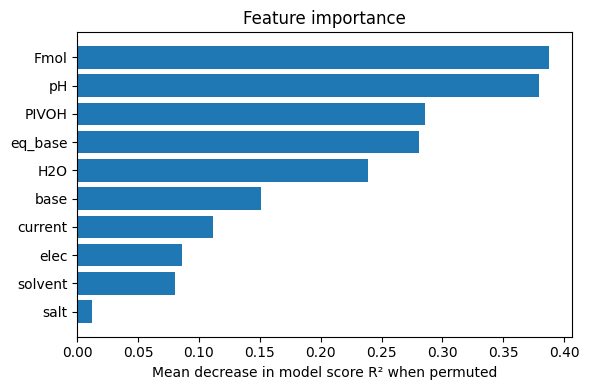

salt                 importance: 0.0122
solvent              importance: 0.0803
elec                 importance: 0.0859
current              importance: 0.1115
base                 importance: 0.1506
H2O                  importance: 0.2385
eq_base              importance: 0.2808
PIVOH                importance: 0.2859
pH                   importance: 0.3796
Fmol                 importance: 0.3872


In [12]:
r = permutation_importance(gp2, X.values, y2, n_repeats=100, random_state=42)

# Features you want to plot
features_to_plot = ["current", "PIVOH", "eq_base", "Fmol", "H2O", "pH", "base", "solvent", "salt", "elec"]

# Get their corresponding importances in the same order
importances = r.importances_mean[[X.columns.get_loc(c) for c in features_to_plot]]

# --- Sort them in descending order ---
sorted_idx = np.argsort(importances)[::]   # [::-1] for ascending
features_sorted = np.array(features_to_plot)[sorted_idx]
importances_sorted = importances[sorted_idx]

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.barh(features_sorted, importances_sorted)
plt.xlabel("Mean decrease in model score R² when permuted")
plt.title("Feature importance")
plt.tight_layout()
plt.savefig("Feature importance.svg")
plt.show()

# Print sorted importances
for f, imp in zip(features_sorted, importances_sorted):
    print(f"{f:20s} importance: {imp:.4f}")


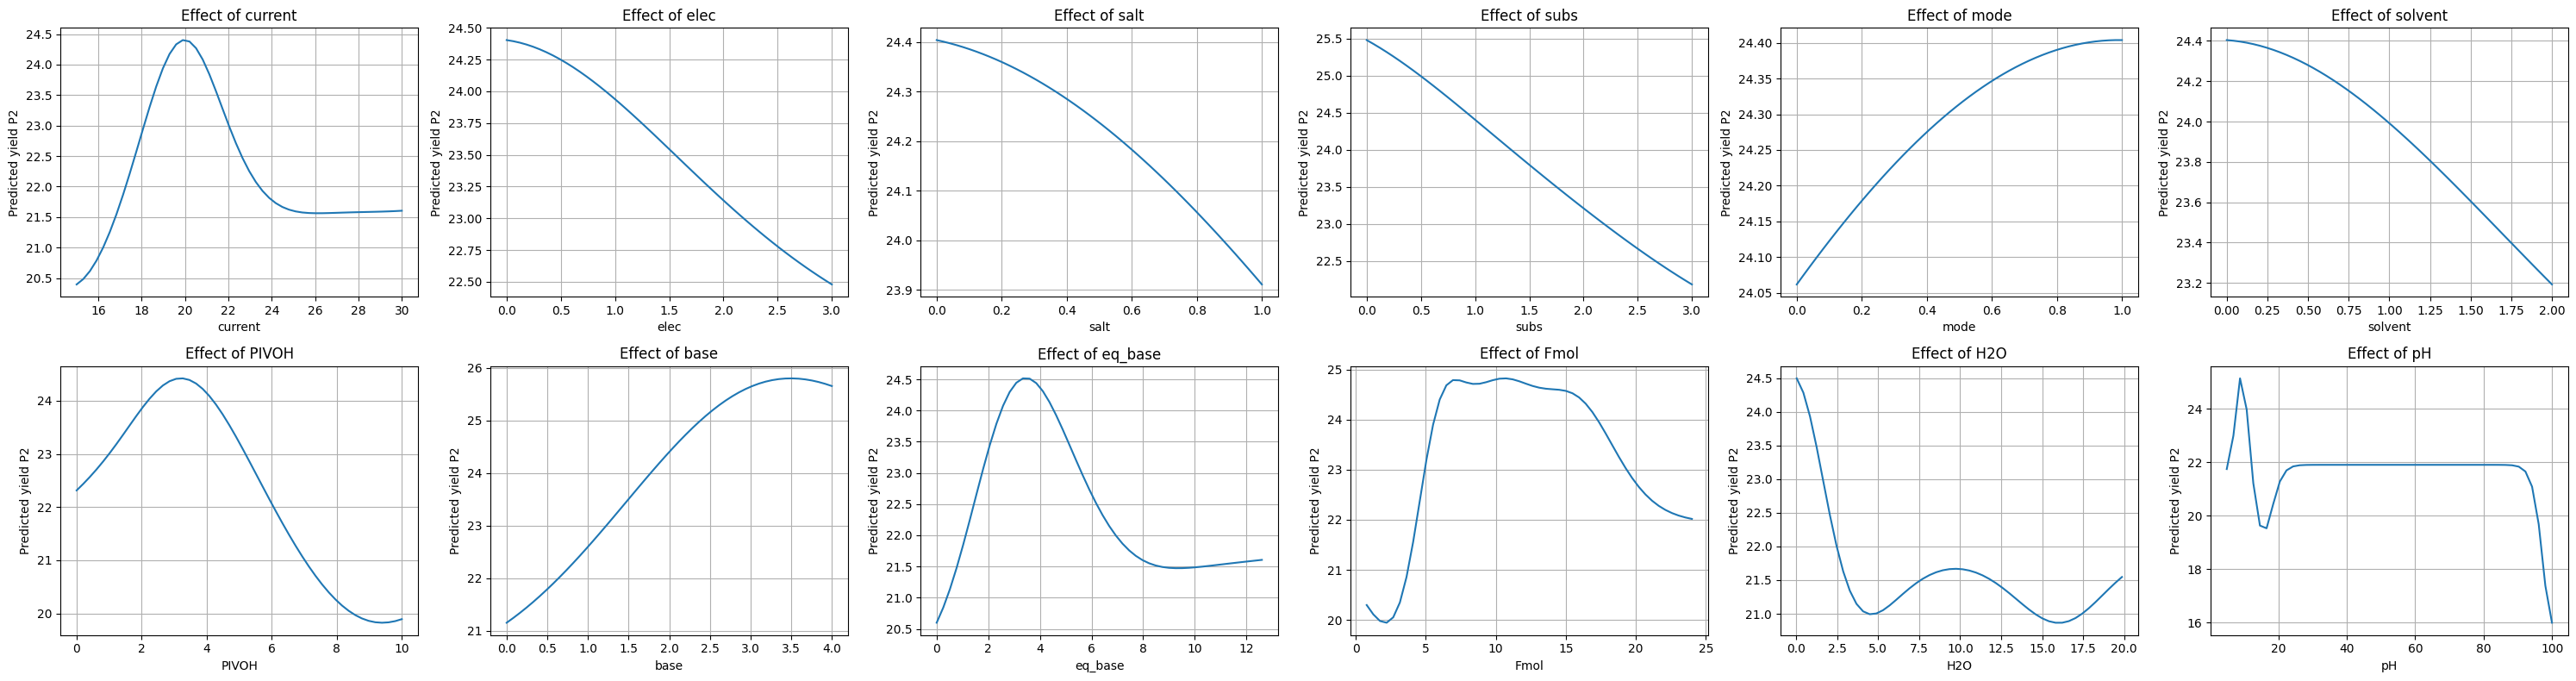

In [13]:
feature_names = X.columns
n = len(feature_names)

# Choose grid size (square-ish)
ncols = 6
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()   # flatten for easy indexing

for i, f in enumerate(feature_names):
    ax = axes[i]
    
    grid = np.linspace(X[f].min(), X[f].max(), 50)
    
    X_ref = X.median().values.reshape(1, -1).repeat(50, axis=0)
    X_ref[:, i] = grid
    
    y_pred = gp2.predict(X_ref)
    
    ax.plot(grid, y_pred)
    ax.set_xlabel(f)
    ax.set_ylabel("Predicted yield P2")
    ax.set_title(f"Effect of {f}")
    ax.grid(True)

# Hide any empty subplots if number of features is not a multiple of ncols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.show()


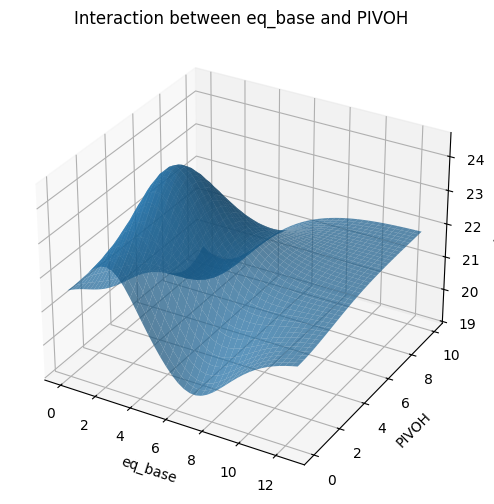

In [ ]:
f1 = "eq_base"
f2 = "PIVOH"

xgrid = np.linspace(X[f1].min(), X[f1].max(), 40)
ygrid = np.linspace(X[f2].min(), X[f2].max(), 40)

XX, YY = np.meshgrid(xgrid, ygrid)

points = X.median().values.reshape(1, -1).repeat(40*40, axis=0)

i1 = list(X.columns).index(f1)
i2 = list(X.columns).index(f2)

points[:, i1] = XX.ravel()
points[:, i2] = YY.ravel()

ZZ = gp2.predict(points).reshape(40, 40)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(XX, YY, ZZ, alpha=0.7)
ax.set_xlabel(f1)
ax.set_ylabel(f2)
ax.set_zlabel("Yield P2")
plt.title(f"Interaction between {f1} and {f2}")
plt.savefig(f"Interaction between {f1} and {f2}.svg")

plt.show()

100%|██████████| 94/94 [01:04<00:00,  1.47it/s]


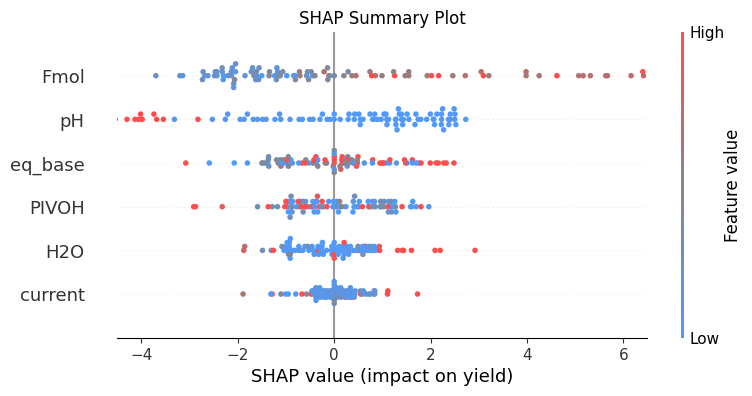

In [15]:
explainer = shap.KernelExplainer(gp2.predict, X)
shap_values = explainer.shap_values(X)

features_to_plot = ["current", "PIVOH", "eq_base", "Fmol", "H2O", "pH"]

plot_style= "dot" #["bar", "dot", "violin", "bar", "layered_violin"]

colors = ["#4F9AFF", "#878787","#ff4c4c"]   # blue → grey → red
my_cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

shap.summary_plot(
    shap_values[:, [X.columns.get_loc(c) for c in features_to_plot]],
    X[features_to_plot],
    plot_type=plot_style,
    cmap=my_cmap,
    show=False)

ax = plt.gca()
ax.set_xlim(-4.5, 6.5)

plt.xlabel("SHAP value (impact on yield)")
plt.title("SHAP Summary Plot")

#save fig as svg
plt.savefig(f"shap_summary_continuous_{plot_style}_yield2.svg")
plt.show()


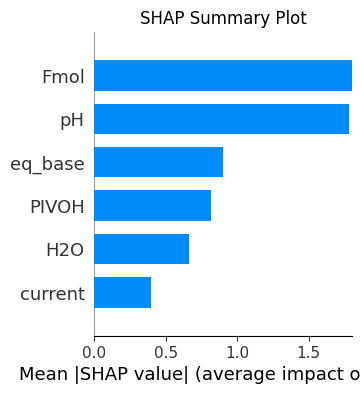

In [16]:
plot_style= "bar" #["bar", "dot", "violin", "bar", "layered_violin"]

shap.summary_plot(
    shap_values[:, [X.columns.get_loc(c) for c in features_to_plot]],
    X[features_to_plot],
    plot_type=plot_style,
    # cmap=my_cmap)
    show=False)

ax = plt.gca()
ax.set_xlim(0, 1.8)
ax.figure.set_size_inches(3, 3.8)

plt.xlabel("Mean |SHAP value| (average impact on yield)")
plt.title("SHAP Summary Plot")

#save fig as svg
plt.savefig(f"shap_summary_continuous_{plot_style}_yield2.svg")
plt.show()

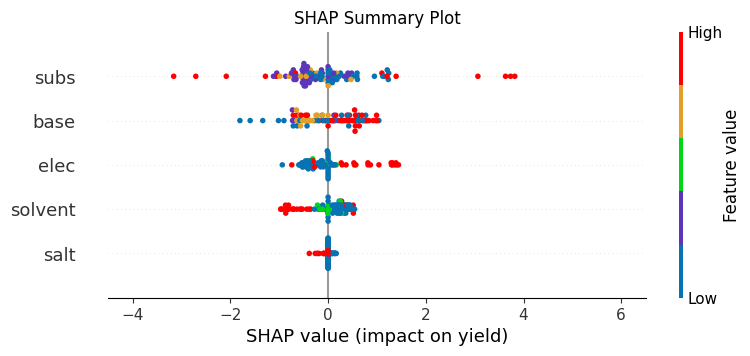

In [17]:
features_to_plot =["base", "solvent", "salt", "elec", "subs"]
idx = [X.columns.get_loc(c) for c in features_to_plot]

colors = mcolors.ListedColormap(["#0773b2", "#5d35ba","#00d619", "#e69f25", "#ff0000"])  # black, green, yellow, red, blue
plot_style= "dot" # can be "dot", "violin", "bar", "layered_violin"

shap.summary_plot(
    shap_values[:, idx],
    X.iloc[:, idx],
    cmap=colors,
    plot_type=plot_style,
    show=False)

ax = plt.gca()
ax.set_xlim(-4.5, 6.5)

plt.xlabel("SHAP value (impact on yield)")
plt.title("SHAP Summary Plot")

#save fig as svg
plt.savefig(f"shap_summary_categorical_{plot_style}_yield2.svg")
plt.show()

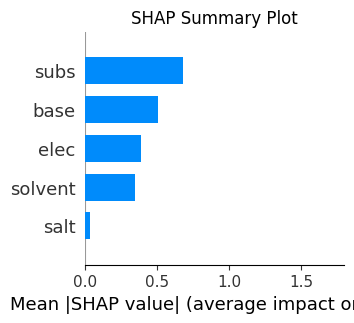

In [18]:
features_to_plot = ["base", "solvent", "salt", "elec", "subs"]

# colors = mcolors.ListedColormap(["#4fc1e8", "#ac92eb","#a0d568", "#ffce54", "#ed5564"])  # black, green, yellow, red, blue
colors = mcolors.ListedColormap(["#009fff", "#5d35ba","#00d619", "#ffdb00", "#ff0000"])  # black, green, yellow, red, blue
plot_style= "bar" # can be "dot", "violin", "bar", "layered_violin"


shap.summary_plot(
    shap_values[:, [X.columns.get_loc(c) for c in features_to_plot]],
    X[features_to_plot],
    cmap=colors,
    plot_type=plot_style,
    show=False)

ax = plt.gca()
ax.set_xlim(0, 1.8)
ax.figure.set_size_inches(3, 3)

plt.xlabel("Mean |SHAP value| (average impact on yield)")
plt.title("SHAP Summary Plot")

#save fig as svg
plt.savefig(f"shap_summary_categorical_{plot_style}_yield2.svg")
plt.show()